In [2]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb
from skimage import data
from skimage.filters import threshold_otsu
# , threshold_adaptive
from skimage import morphology
from skimage.color import label2rgb
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
import torch
import matplotlib.pyplot as plt
import os

In [3]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

# # networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 2
if model_id == 1:
    net = models.squeezenet1_1(num_classes=20)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(num_classes=20)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(num_classes=20)
    finalconv_name = 'features'
elif model_id == 4:
    net = models.vgg16(num_classes=20)
    finalconv_name = 'features'

# net = models.resnet101(num_classes=20)
# finalconv_name = 'layer4'


checkpoint = torch.load('checkpoints/voc_resnet18/model_best.pth.tar')
model_state = checkpoint['state_dict']
new_model = dict()
for k, v in model_state.items():
    newk = k.replace('module.', '')
    new_model[newk] = v
    
net.load_state_dict(new_model)
net.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [4]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())


In [482]:
for p in params:
    print(p.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [5]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam



In [6]:
def returnCAM_vgg(feature_conv, params, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = params[-2].mm(params[-4]).mm(params[-6])[idx] *torch.tensor(feature_conv.reshape(nc*h*w))
#         cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w))
        cam = cam.reshape((nc, h, w)).sum(0).data.numpy()
#         cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [7]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
# path = '/export/home/ehsan/ehsan-scratchpad/object_detection/weakly_supervised/ws_frcnn/data/VOCdevkit2007/VOC2007/JPEGImages/000012.jpg'
# img_pil = Image.open(path)
# img_pil.save('test.jpg')


0.998 -> horse
0.001 -> person
0.000 -> cow
0.000 -> chair
0.000 -> dog


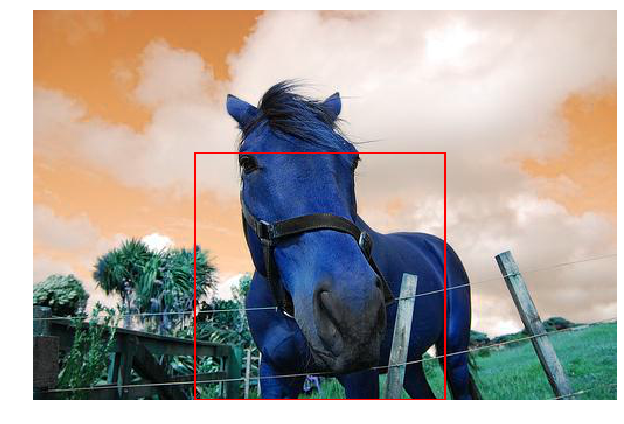

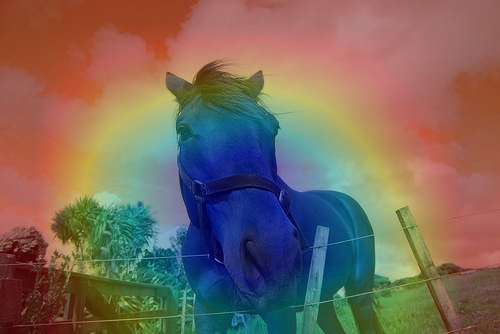

In [17]:
dir = '/export/home/ehsan/ehsan-scratchpad/object_detection/weakly_supervised/ws_frcnn/data/VOCdevkit2007/VOC2007/JPEGImages'
img_id = '000056'

threshold = 0.65

path = os.path.join(dir, img_id)+'.jpg'
img_pil = Image.open(path)
img_pil.save('test.jpg')

width, height = img_pil.size

features_blobs = []

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

# download the imagenet category list
# classes = {int(key):value for (key, value)
#           in requests.get(LABELS_URL).json().items()}

categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

classes = {}
for i, k in enumerate(categories):
    classes[i] = k
    
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

img = cv2.imread('test.jpg')

topk = 0
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[topk]])


CAMs_scaled = [cv2.resize(c,(width, height)) for c in CAMs]
binary_globals = [h > threshold * h.max() for h in CAMs_scaled]
# all_globals = sum(binary_globals)
all_globals = binary_globals[0]
label_image = label(all_globals>0, connectivity=2, background=0)
image_label_overlay = label2rgb(label_image, image=img)


fig, ax = plt.subplots(figsize=(10, 6))

ax.imshow(np.array(img))
for region in regionprops(label_image):
    # take regions with large enough areas
     if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
Image.fromarray(result.astype('uint8'))



In [8]:
edgemodel = cv2.ximgproc.createStructuredEdgeDetection('model.yml')

In [9]:
# gray = cv2.imread('test.jpg', cv2.IMREAD_GRAYSCALE)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = gray
img = cv2.imread('test.jpg')
img = (img-img.min())/img.max()
edges = edgemodel.detectEdges(img.astype('float32'))

In [10]:
e8u = (edges * 255).astype('uint8')

In [11]:
orientation_map = edgemodel.computeOrientation(edges)

In [12]:
edges_nms = edgemodel.edgesNms(edges, orientation_map)

In [13]:
edge_boxes = cv2.ximgproc.createEdgeBoxes()
edge_boxes.setMaxBoxes(30)
boxes = edge_boxes.getBoundingBoxes(edges, orientation_map)


In [14]:
for b in boxes:
    x, y, w, h = b
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

In [ ]:
# cv2.imshow("edges", edges)
cv2.imshow("edgeboxes", img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


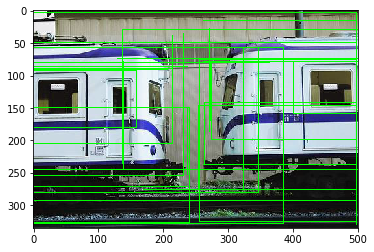

In [16]:
plt.imshow(img)

In [581]:
features_blobs = []

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

# download the imagenet category list
# classes = {int(key):value for (key, value)
#           in requests.get(LABELS_URL).json().items()}

categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

classes = {}
for i, k in enumerate(categories):
    classes[i] = k
    
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()


In [582]:
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))


0.784 -> bicycle
0.136 -> person
0.046 -> train
0.009 -> motorbike
0.008 -> horse


In [583]:


# generate class activation mapping for the top1 prediction

topk = 0
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[topk]])

# CAMs = returnCAM_vgg(features_blobs[0], params, [idx[0]])


# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[topk]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)


output CAM.jpg for the top1 prediction: bicycle


True

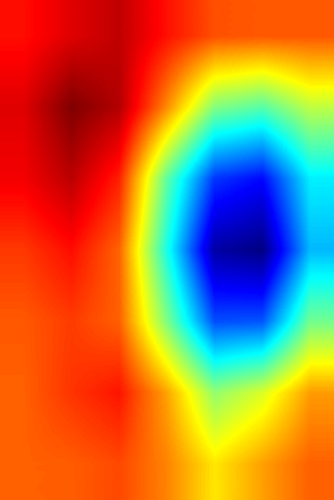

In [584]:
Image.fromarray(heatmap)

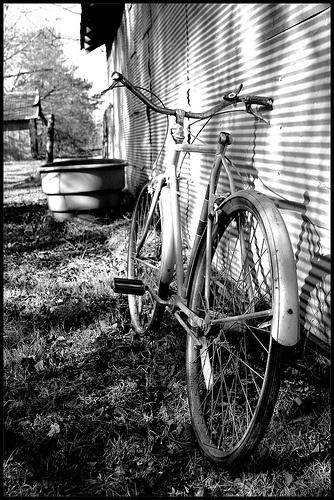

In [585]:
Image.fromarray(img)

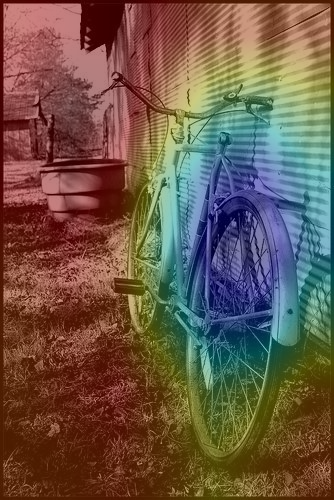

In [586]:
Image.fromarray(result.astype('uint8'))

In [587]:

CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0], idx[1], idx[2], idx[3], idx[4]])
results = []
heatmaps = []
for i in range(5):
    # render the CAM and output
    print('output CAM{}.jpg for the top{} prediction: {}'.format(i, i, classes[idx[i]]))
    img = cv2.imread('test.jpg')
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
    heatmaps.append(heatmap)
    result = heatmap * 0.3 + img * 0.5
    results.append(result)
    cv2.imwrite('CAM_{}.jpg'.format(i), result)


output CAM0.jpg for the top0 prediction: bicycle
output CAM1.jpg for the top1 prediction: person
output CAM2.jpg for the top2 prediction: train
output CAM3.jpg for the top3 prediction: motorbike
output CAM4.jpg for the top4 prediction: horse


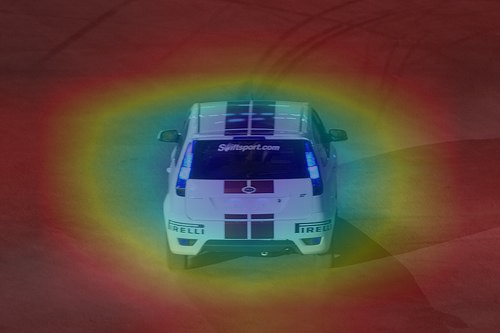

In [561]:
Image.fromarray(results[0].astype('uint8'))

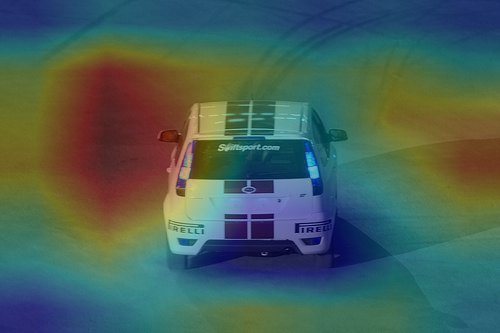

In [562]:
Image.fromarray(results[1].astype('uint8'))

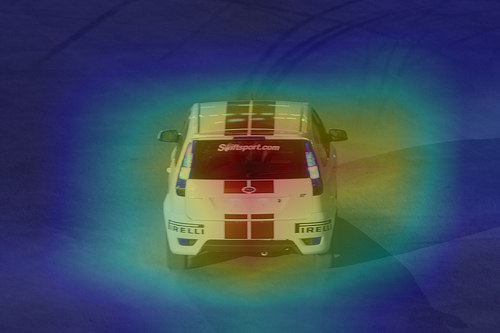

In [563]:
Image.fromarray(results[2].astype('uint8'))

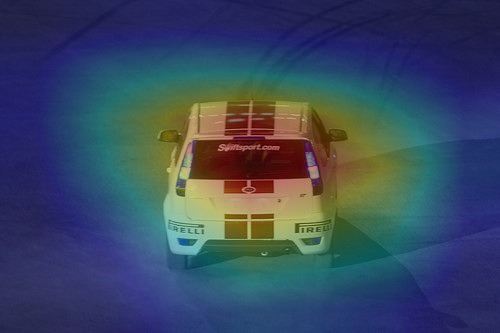

In [564]:
Image.fromarray(results[3].astype('uint8'))

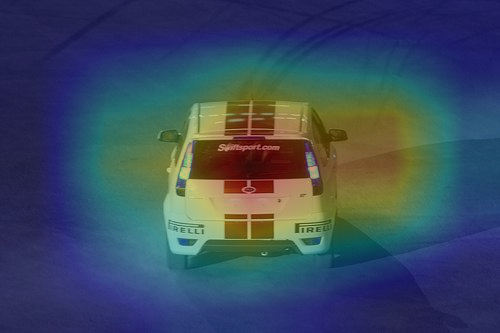

In [565]:
Image.fromarray(results[4].astype('uint8'))

In [588]:
# global_thresh = threshold_otsu(heatmap)
# binary_global = heatmap > 0.2*heatmap.max()
CAMs_scaled = [cv2.resize(c,(width, height)) for c in CAMs]
binary_globals = [h > 0.7 * h.max() for h in CAMs_scaled]
# all_globals = sum(binary_globals)
all_globals = binary_globals[0]

In [589]:
label_image = label(all_globals>0, connectivity=2, background=0)
image_label_overlay = label2rgb(label_image, image=img)

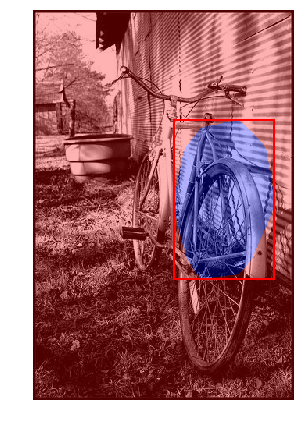

In [590]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [592]:
Image.open('test.jpg').size

(334, 500)

In [593]:
img.shape

(500, 334, 3)

In [594]:
all_globals.shape

(500, 334)

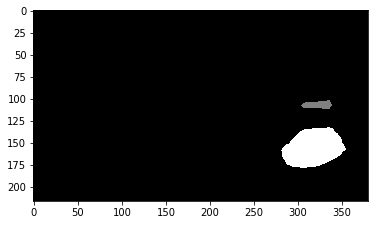

In [171]:
mask = morphology.label(binary_globals[0], connectivity=2, background=0)
plt.imshow(mask*255, cmap=plt.get_cmap('gray'))

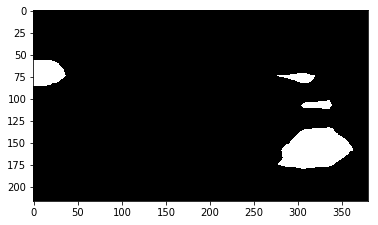

In [192]:
all_global = sum(binary_globals)
plt.imshow(sum(binary_globals)>0)

In [186]:
np.unique(all_global)

array([0, 1, 2, 3, 4])